In [150]:
import pandas as pd
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
from statsmodels.graphics import utils
from scipy import stats

from reload_recursive import reload_recursive

import mri_data

In [151]:
reload_recursive(mri_data)
from mri_data import utils as mri_utils

In [115]:
analysis_dir = Path("/home/srs-9/Projects/ms_mri/analysis")
df_t1 = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain_t1" / "dataframe.csv")
df_flair = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain_flair" / "dataframe.csv")
df_t1_flair = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain" / "dataframe.csv")

curr_dir = analysis_dir / "paper1"

### Mean Difference Plot Function

Adapted from statsmodels.graphics.agreement

In [93]:
# adapted from statsmodels.graphics.agreement
def mean_diff_plot(m1, m2, sd_limit=1.96, ax=None, scatter_kwds=None,
                   mean_line_kwds=None, limit_lines_kwds=None, ylabels=True):
    """
    Construct a Tukey/Bland-Altman Mean Difference Plot.

    Tukey's Mean Difference Plot (also known as a Bland-Altman plot) is a
    graphical method to analyze the differences between two methods of
    measurement. The mean of the measures is plotted against their difference.

    For more information see
    https://en.wikipedia.org/wiki/Bland-Altman_plot

    Parameters
    ----------
    m1 : array_like
        A 1-d array.
    m2 : array_like
        A 1-d array.
    sd_limit : float
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted are md +/- sd_limit * sd.
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences. If sd_limit = 0, no limits will be plotted, and
        the ylimit of the plot defaults to 3 standard deviations on either
        side of the mean.
    ax : AxesSubplot
        If `ax` is None, then a figure is created. If an axis instance is
        given, the mean difference plot is drawn on the axis.
    scatter_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method

    Returns
    -------
    Figure
        If `ax` is None, the created figure.  Otherwise the figure to which
        `ax` is connected.

    References
    ----------
    Bland JM, Altman DG (1986). "Statistical methods for assessing agreement
    between two methods of clinical measurement"

    Examples
    --------

    Load relevant libraries.

    >>> import statsmodels.api as sm
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt

    Making a mean difference plot.

    >>> # Seed the random number generator.
    >>> # This ensures that the results below are reproducible.
    >>> np.random.seed(9999)
    >>> m1 = np.random.random(20)
    >>> m2 = np.random.random(20)
    >>> f, ax = plt.subplots(1, figsize = (8,5))
    >>> sm.graphics.mean_diff_plot(m1, m2, ax = ax)
    >>> plt.show()

    .. plot:: plots/graphics-mean_diff_plot.py
    """
    fig, ax = utils.create_mpl_ax(ax)

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError(f'sd_limit ({sd_limit}) is less than 0.')

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'

    ax.scatter(means, diffs, **scatter_kwds) # Plot the means against the diffs.
    ax.axhline(mean_diff, **mean_line_kwds)  # draw mean line.

    # Annotate mean line with mean difference.
    ax.annotate(f'mean diff:\n{np.round(mean_diff, 2)}',
                xy=(0.99, 0.5),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=14,
                xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)
        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        ax.annotate(f'-{sd_limit} SD: {lower:0.2g}',
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
        ax.annotate(f'+{sd_limit} SD: {upper:0.2g}',
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')

    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    if ylabels:
        ax.set_ylabel('Difference', fontsize=15)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    fig.tight_layout()
    return fig


### Z-Score Function

Get z scores of the difference between inference and manual volume

In [94]:
def zscores(data, struct):
    
    return abs(stats.zscore((data[f'{struct}_vol_auto'] - data[f'{struct}_vol_man']), nan_policy='omit'))

### Bland-Altman Plots

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


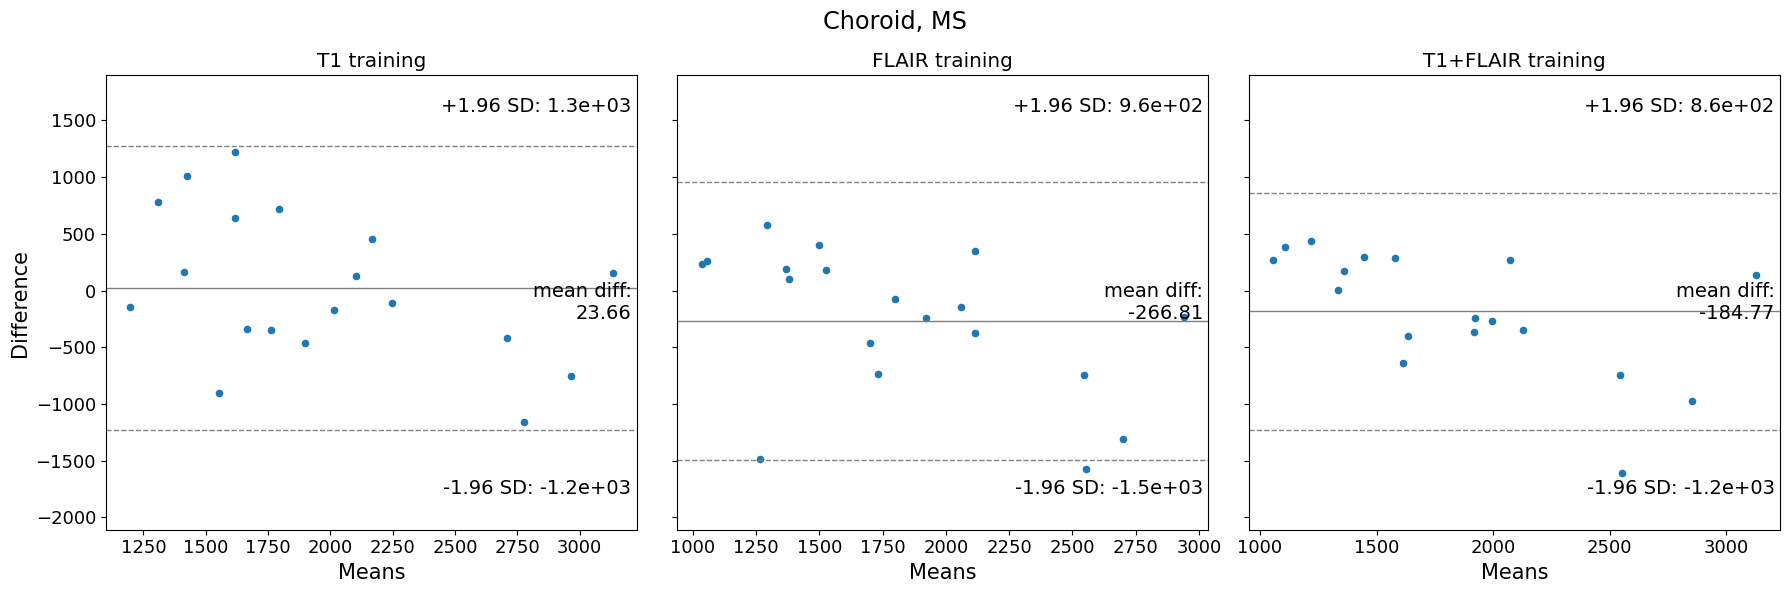

In [95]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Choroid, MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "MS", :]
print("T1 outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "MS", :]
print("FLAIR outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

plt.show()

data = df_flair.loc[df_t1["dz_type2"] == "MS", :]
stat, p = stats.wilcoxon(data['choroid_vol_auto'], data["choroid_vol_man"])

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


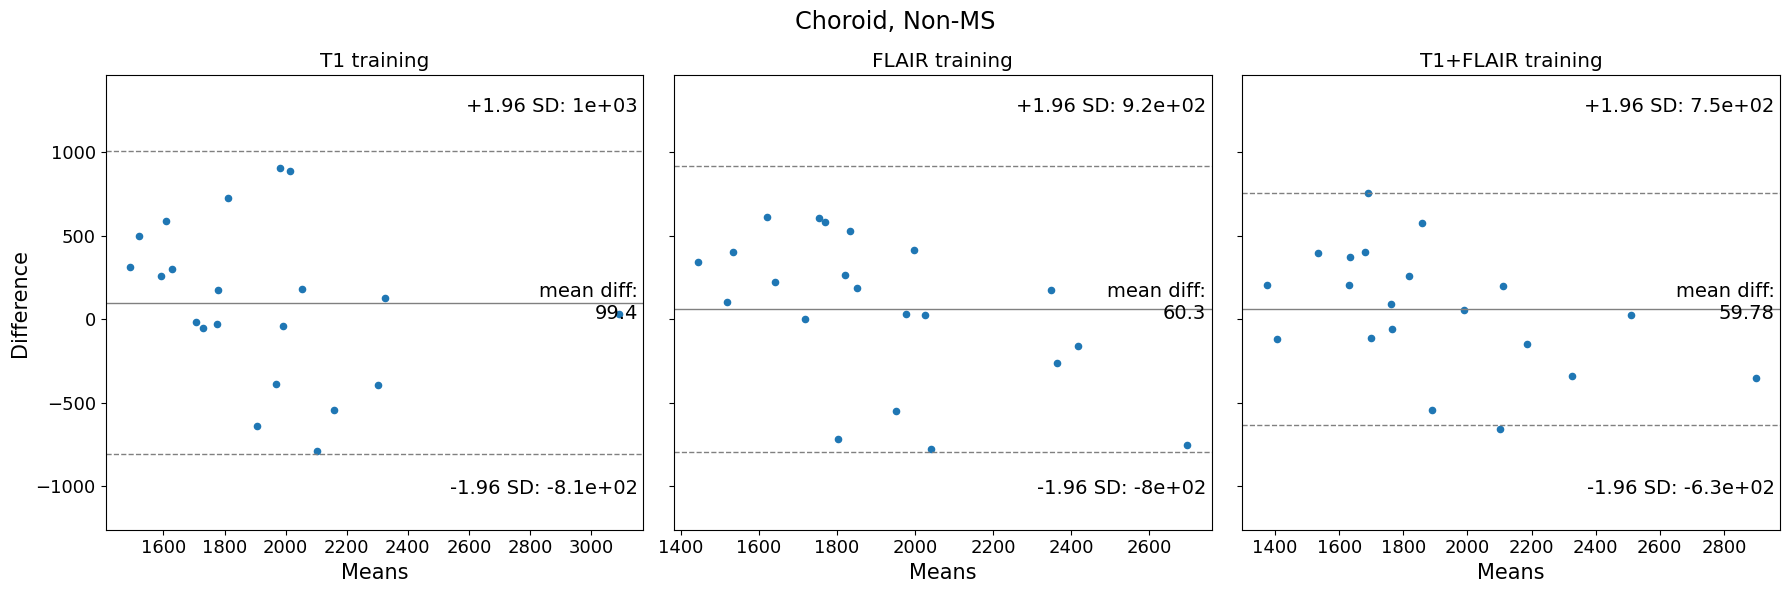

In [6]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Choroid, Non-MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "!MS", :]
print("T1 outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "!MS", :]
print("FLAIR outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "!MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "choroid") >= 3))
data = data[zscores(data, "choroid") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["choroid_vol_auto"], data["choroid_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


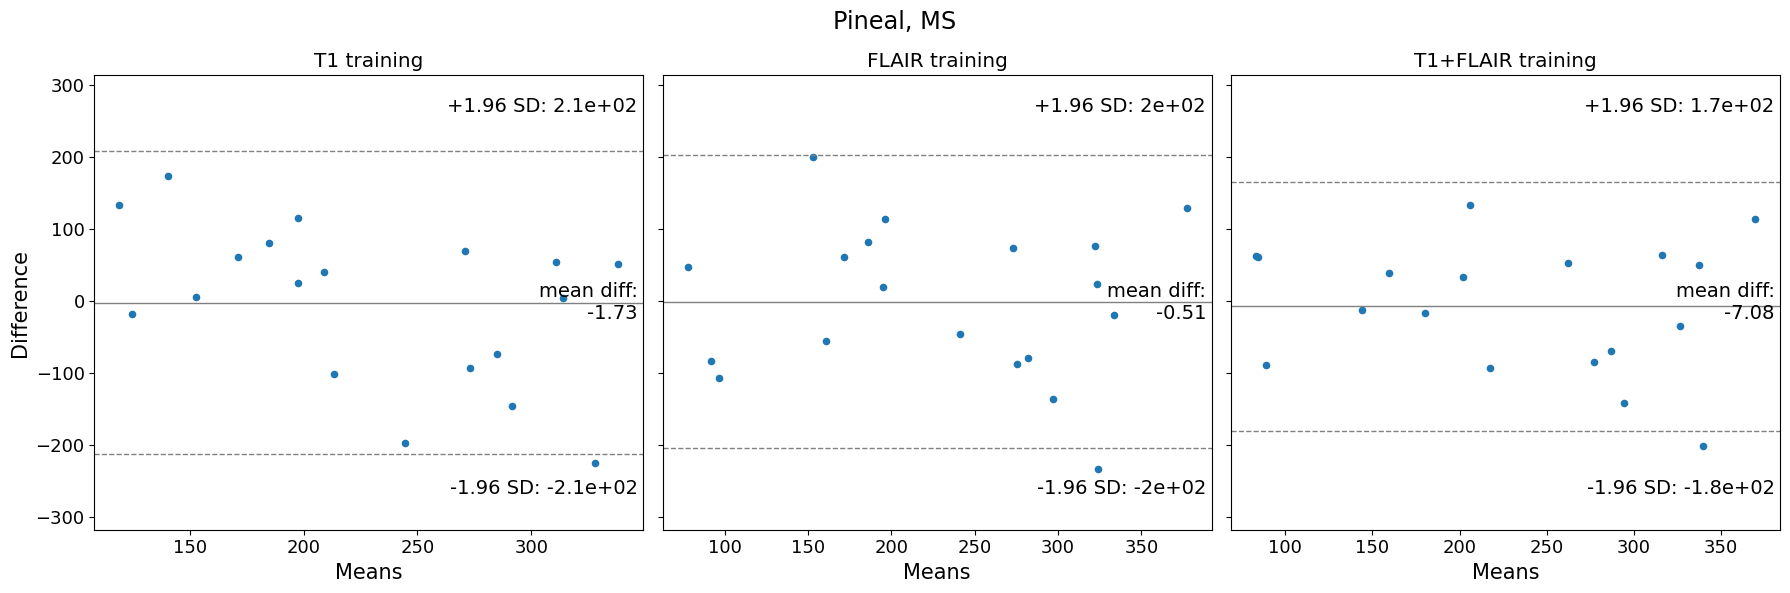

In [7]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Pineal, MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "MS", :]
print("T1 outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "MS", :]
print("FLAIR outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

T1 outliers: 1
FLAIR outliers: 1
T1+FLAIR outliers: 1


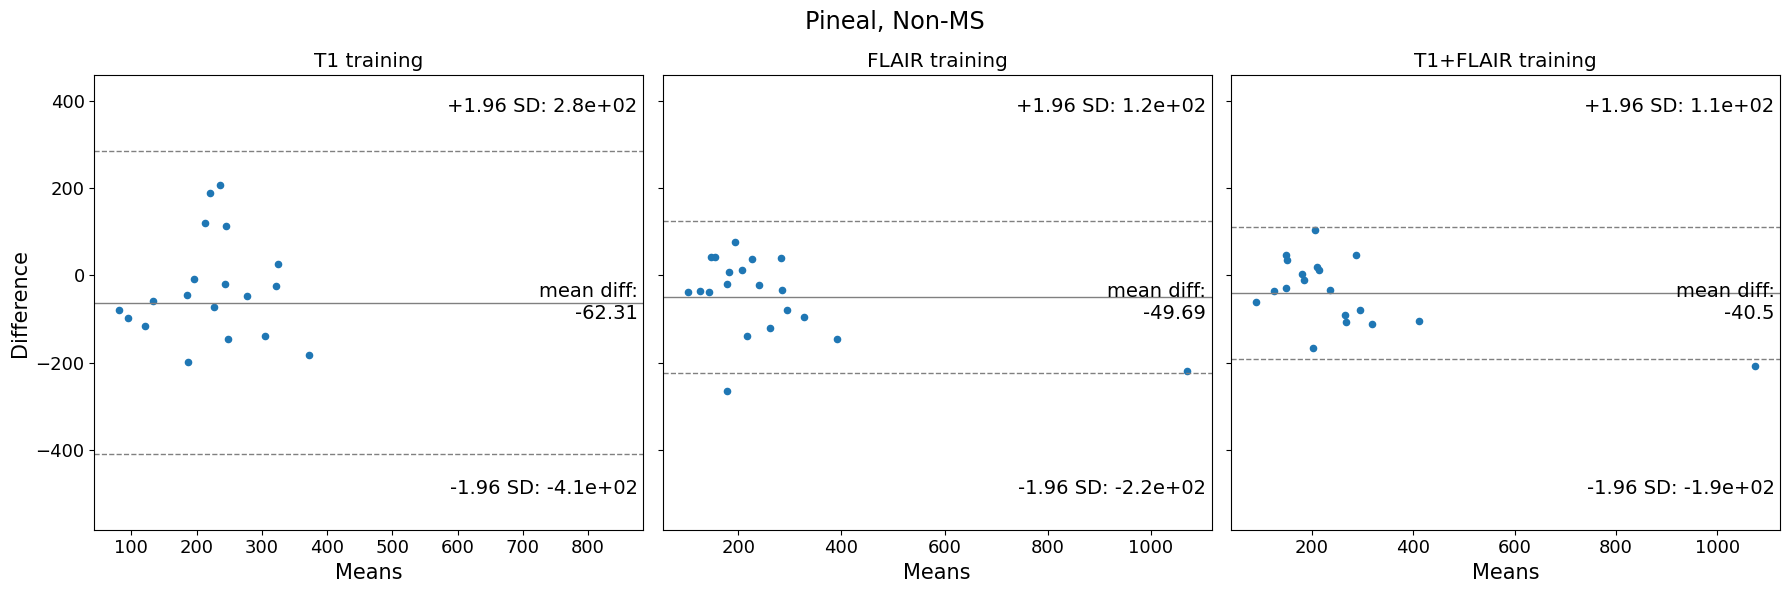

In [8]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Pineal, Non-MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "!MS", :]
print("T1 outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "!MS", :]
print("FLAIR outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "!MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "pineal") >= 3))
data = data[zscores(data, "pineal") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["pineal_vol_auto"], data["pineal_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


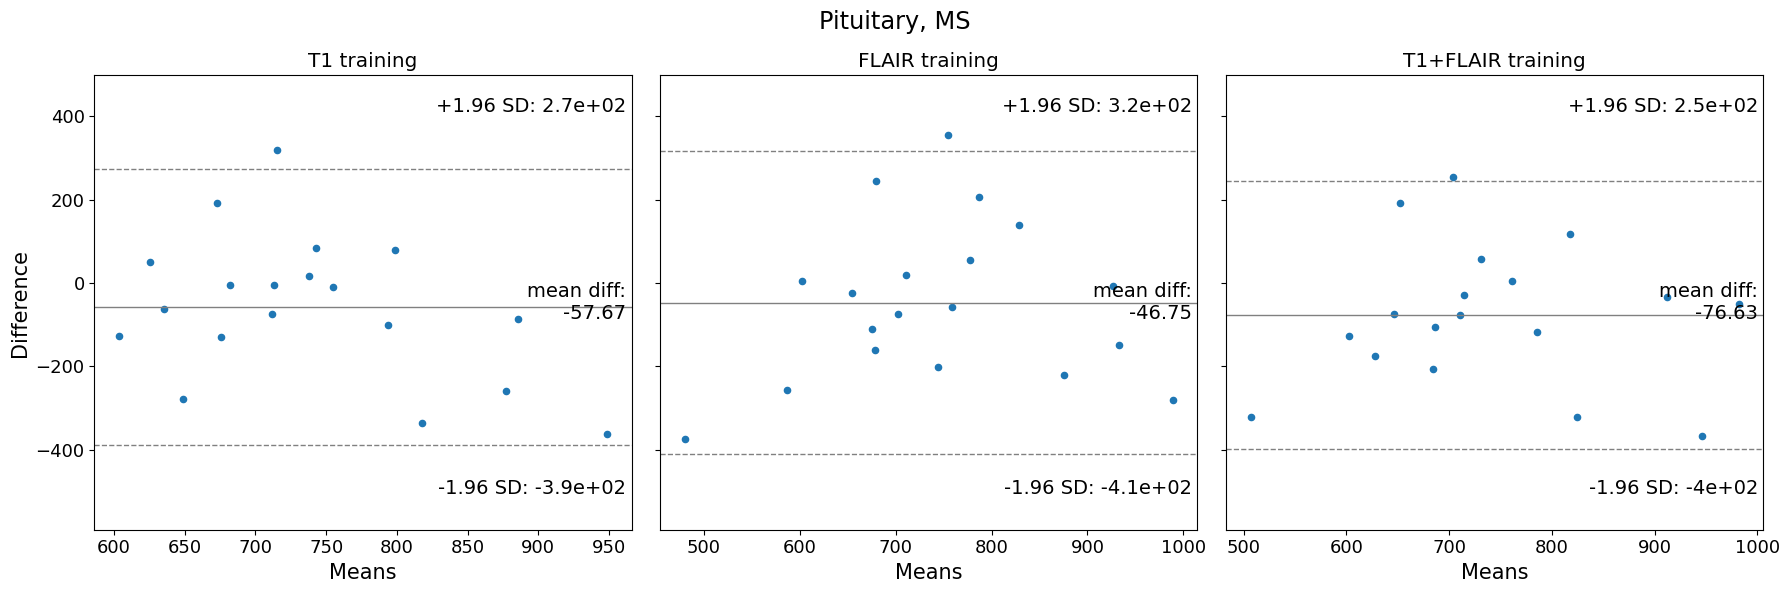

In [9]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Pituitary, MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "MS", :]
print("T1 outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "MS", :]
print("FLAIR outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

T1 outliers: 1
FLAIR outliers: 0
T1+FLAIR outliers: 0


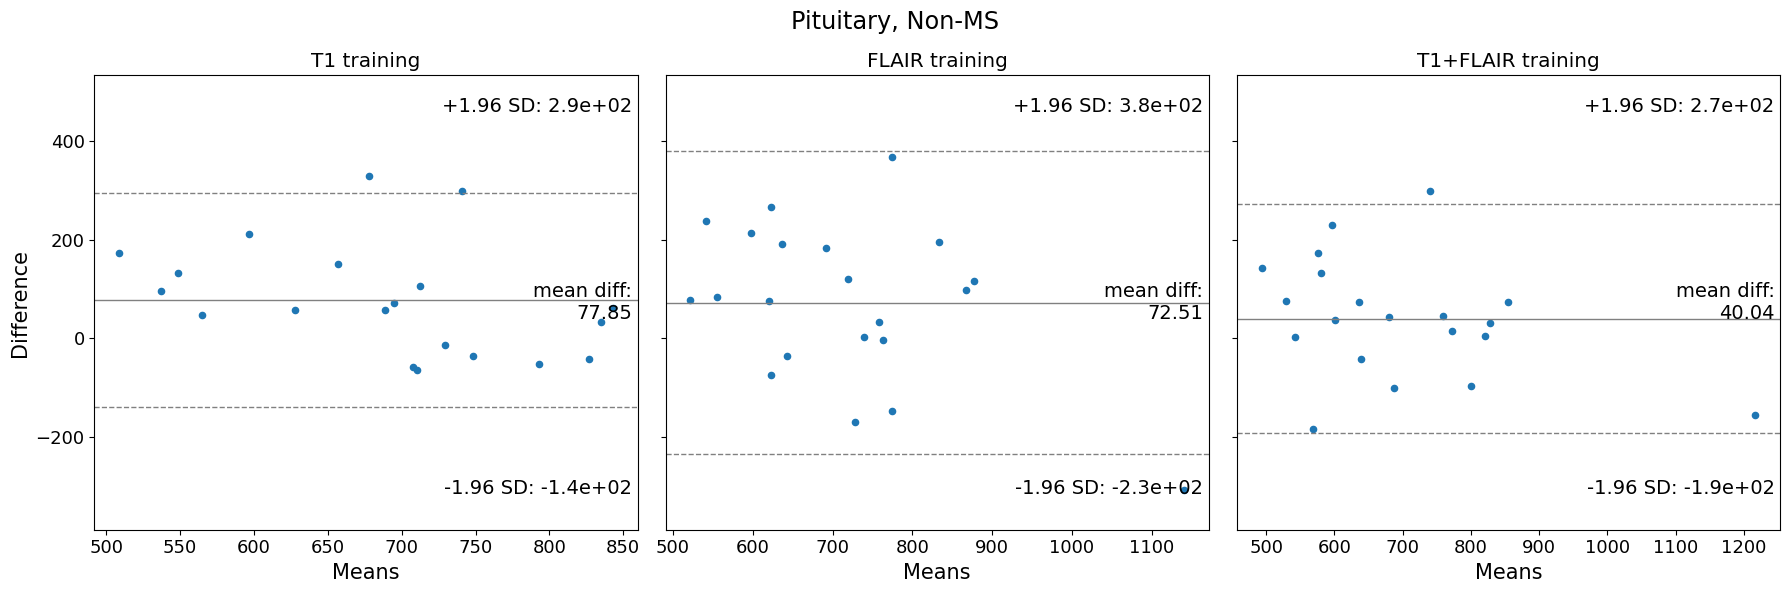

In [10]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.suptitle("Pituitary, Non-MS", size="xx-large")

lims = []

ax = axes[0]
data = df_t1.loc[df_t1["dz_type2"] == "!MS", :]
print("T1 outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("T1 training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
data = df_flair.loc[df_flair["dz_type2"] == "!MS", :]
print("FLAIR outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("FLAIR training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

ax = axes[2]
data = df_t1_flair.loc[df_t1_flair["dz_type2"] == "!MS", :]
print("T1+FLAIR outliers:", sum(zscores(data, "pituitary") >= 3))
data = data[zscores(data, "pituitary") < 3]
ax.set_title("T1+FLAIR training", size="x-large")
mean_diff_plot(data["pituitary_vol_auto"], data["pituitary_vol_man"], ax=ax, ylabels=False)
lims.append(ax.get_ylim())

y1 = y2 = 0
for lim in lims:
    if abs(lim[0]) > abs(y1):
        y1 = lim[0]
    if abs(lim[1]) > abs(y2):
        y2 = lim[1]

for ax in axes:
    ax.set_ylim([y1, y2])

In [102]:
def bland_altman_plots(cond, struct):
    auto_col = f"{struct}_vol_auto"
    man_col = f"{struct}_vol_man"
    
    f, axes = plt.subplots(1, 3, figsize = (18,6))
    f.suptitle(f"{struct.title()}, Non-MS", size="xx-large")

    lims = []

    ax = axes[0]
    data = df_t1.loc[cond(df_t1), :]
    print("T1 outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("T1 training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax)
    lims.append(ax.get_ylim())

    ax = axes[1]
    data = df_flair.loc[cond(df_flair), :]
    print("FLAIR outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("FLAIR training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax, ylabels=False)
    lims.append(ax.get_ylim())

    ax = axes[2]
    data = df_t1_flair.loc[cond(df_t1_flair), :]
    print("T1+FLAIR outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("T1+FLAIR training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax, ylabels=False)
    lims.append(ax.get_ylim())

    y1 = y2 = 0
    for lim in lims:
        if abs(lim[0]) > abs(y1):
            y1 = lim[0]
        if abs(lim[1]) > abs(y2):
            y2 = lim[1]

    for ax in axes:
        ax.set_ylim([y1, y2])
    
    return f

In [103]:
def ms_wcontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITH")

def ms_wocontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITHOUT")

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


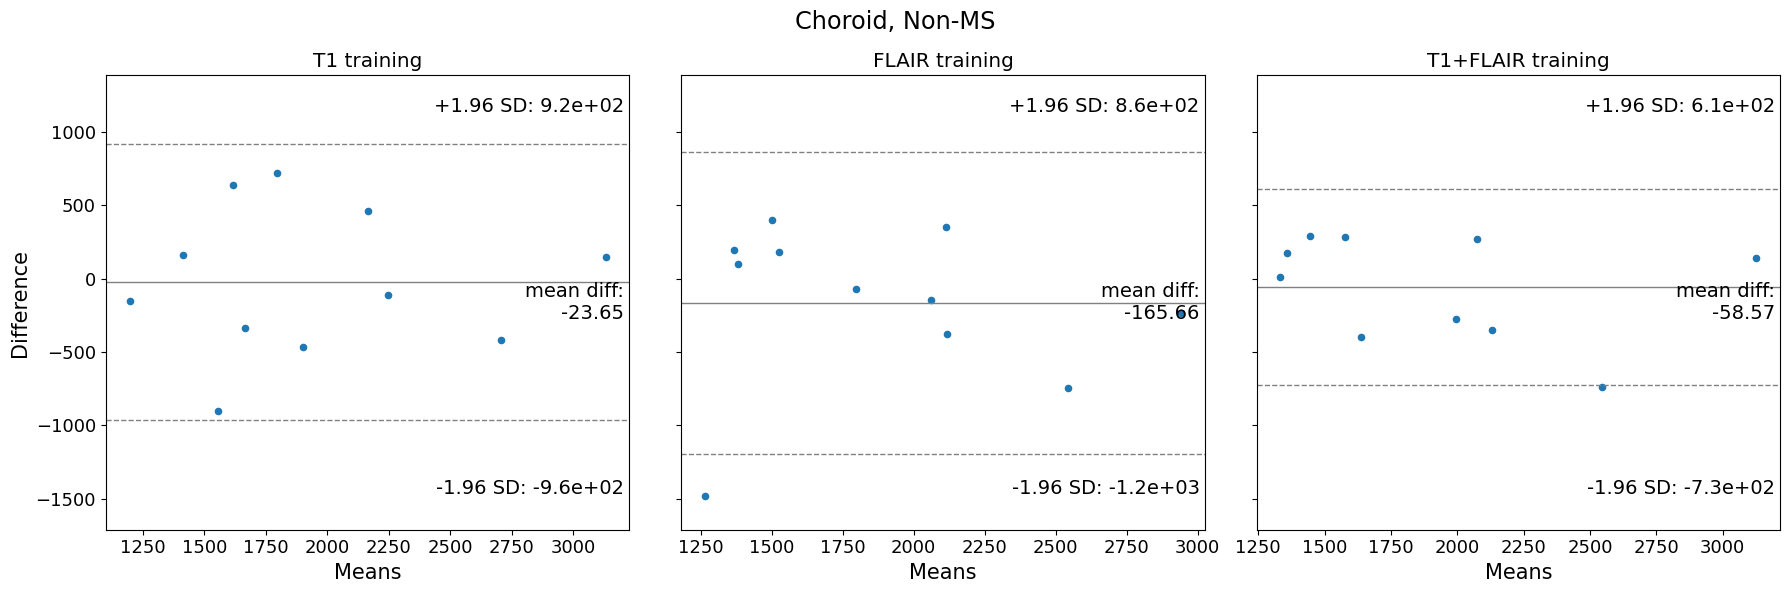

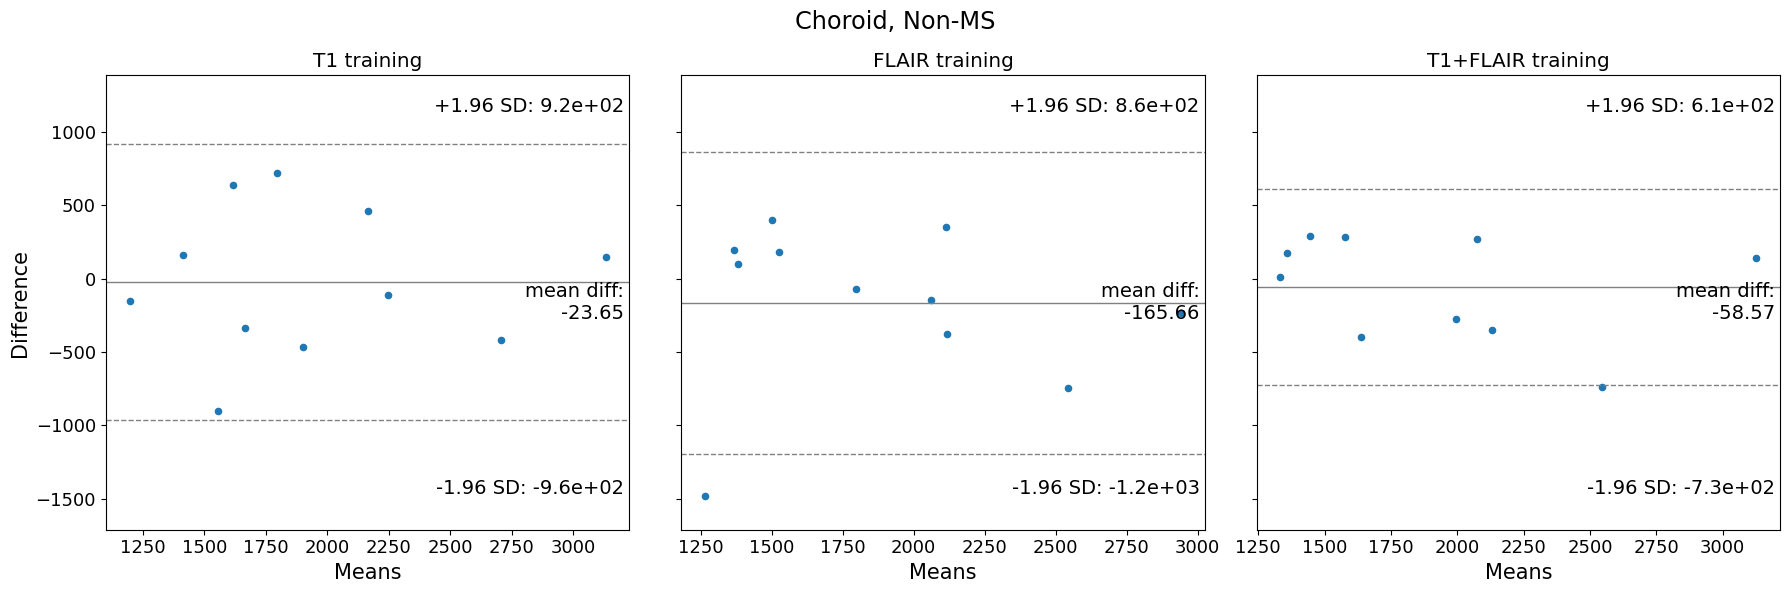

In [105]:
bland_altman_plots(ms_wcontrast, "choroid")

### Dice Scores

In [142]:
def get_mean_dice_scores(dfs, cond=None):
    if cond is not None:
        dfs = [cond(df) for df in dfs]
    mean_dice_scores = []
    for df in [df_t1, df_flair, df_t1_flair]:
        mean_dice_scores.append({'choroid': round(df['choroid_dice'].mean(), 2),
                                'pineal': round(df['pineal_dice'].mean(), 2),
                                'pituitary': round(df['pituitary_dice'].mean(), 2)})

    df_dice = pd.DataFrame(mean_dice_scores)
    return df_dice

In [145]:
df_dice = get_mean_dice_scores([df_t1, df_flair, df_t1_flair])
df_dice.index=['t1', 'flair', 'flair_t1']
df_dice

,choroid,pineal,pituitary
t1,0.70,0.65,0.82
flair,0.75,0.72,0.73
flair_t1,0.73,0.71,0.76


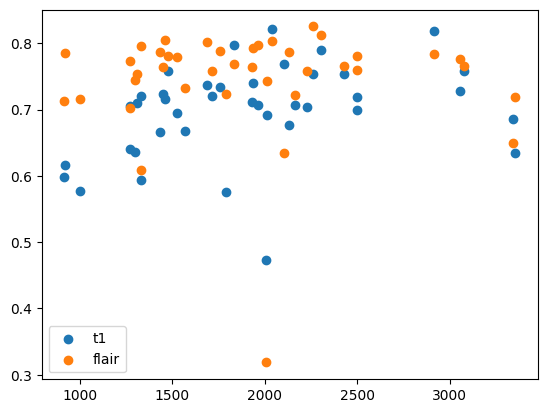

In [138]:
plt.scatter(df_t1['choroid_vol_man'], df_t1['choroid_dice'], label="t1")
plt.scatter(df_flair['choroid_vol_man'], df_flair['choroid_dice'], label="flair")
plt.legend()

### Review Inferences

In [146]:
df = df_t1.loc[:, ['subject_id', 'ms_type', 'flair_contrast']]
df.loc[df['ms_type'].isin(['CIS', 'RRMS']), ['ms_type']] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), ['ms_type']] = 'PMS'

In [147]:
df.loc[:, ['cp_man_vol']] = df_t1['choroid_vol_man']
df.loc[:, ['cp_t1_vol']] = df_t1['choroid_vol_auto']
df.loc[:, ['cp_flair_vol']] = df_flair['choroid_vol_auto']
df.loc[:, ['cp_t1.flair_vol']] = df_t1_flair['choroid_vol_auto']
df.loc[:, ['cp_t1_diff']] = df_t1['choroid_vol_auto'] - df_t1['choroid_vol_man']
df.loc[:, ['cp_flair_diff']] = df_flair['choroid_vol_auto'] - df_flair['choroid_vol_man']
df.loc[:, ['cp_t1_flair_diff']] = df_t1_flair['choroid_vol_auto'] - df_t1_flair['choroid_vol_man']


df.loc[:, ['pin_man_vol']] = df_t1['pineal_vol_man']
df.loc[:, ['pin_t1_vol']] = df_t1['pineal_vol_auto']
df.loc[:, ['pin_flair_vol']] = df_flair['pineal_vol_auto']
df.loc[:, ['pin_t1.flair_vol']] = df_t1_flair['pineal_vol_auto']
df.loc[:, ['pin_t1_diff']] = df_t1['choroid_vol_auto'] - df_t1['choroid_vol_man']
df.loc[:, ['pin_flair_diff']] = df_flair['choroid_vol_auto'] - df_flair['choroid_vol_man']
df.loc[:, ['pin_t1_flair_diff']] = df_t1_flair['choroid_vol_auto'] - df_t1_flair['choroid_vol_man']

df.loc[:, ['pit_man_vol']] = df_t1['pituitary_vol_man']
df.loc[:, ['pit_t1_vol']] = df_t1['pituitary_vol_auto']
df.loc[:, ['pit_flair_vol']] = df_flair['pituitary_vol_auto']
df.loc[:, ['pit_t1.flair_vol']] = df_t1_flair['pituitary_vol_auto']
df.loc[:, ['pit_t1_diff']] = df_t1['choroid_vol_auto'] - df_t1['choroid_vol_man']
df.loc[:, ['pit_flair_diff']] = df_flair['choroid_vol_auto'] - df_flair['choroid_vol_man']
df.loc[:, ['pit_t1_flair_diff']] = df_t1_flair['choroid_vol_auto'] - df_t1_flair['choroid_vol_man']

In [148]:
df = df.set_index('subject_id')

In [149]:
df.to_csv(curr_dir / "crosstrain_inference_volumes.csv")

In [130]:
drive_root = Path("/media/smbshare")
smbshare = Path("/media/smbshare")


def fix_path(path, drive_root, other_root):
    return drive_root / Path(path).relative_to(other_root)

In [127]:
cmds = df_flair[['subject_id', 'ms_type', 'dz_type2', 'flair_contrast']]
for i, row in cmds.iterrows():
    cmds.loc[i, ['manual_label']] = fix_path(df_flair.at[i, 'manual_label'])
    cmds.loc[i, ['flair_label']] = df_flair.at[i, 'auto_label']
    cmds.loc[i, ['t1_label']] = df_t1.at[i, 'auto_label']
    cmds.loc[i, ['t1_flair_label']] = df_t1_flair.at[i, 'auto_label']

cmds = cmds.set_index('subject_id')

In [152]:
cmds = df_flair[['subject_id', 'ms_type', 'dz_type2', 'flair_contrast']]
for i, row in cmds.iterrows():
    man_label = fix_path(df_flair.at[i, 'manual_label'], drive_root, smbshare)
    flair_label = df_flair.at[i, 'auto_label']
    t1_label = df_t1.at[i, 'auto_label']
    t1_flair_label = df_t1_flair.at[i, 'auto_label']
    scan_folder = fix_path(df_flair.at[i, 'scan_folder'], drive_root, smbshare)

    scans = [scan_folder / "t1.nii.gz", scan_folder / "flair.nii.gz"]
    labels = [man_label, flair_label, t1_label]
    cmds.loc[i, ['itksnap_cmd']] = mri_utils.open_itksnap_workspace_cmd(scans, labels, win=False)
    cmds.loc[i, ['fsleyes_cmd']] = mri_utils.fsleyes_cmd(scans, [flair_label, t1_label], [man_label])

cmds = cmds.set_index('subject_id')

In [154]:
import pyperclip
import subprocess

subid = 1037
fsleyes_cmd = cmds.loc[subid, "fsleyes_cmd"]
itksnap_cmd = cmds.loc[subid, "itksnap_cmd"]

subprocess.Popen(itksnap_cmd.split(" "))
subprocess.Popen(fsleyes_cmd.split(" "))

<Popen: returncode: None args: ['fsleyes', '/media/smbshare/3Tpioneer_bids/s...>

Launching ITK-SNAP


Return code : 0
